# Gold Rate and forecast with sklearn and XGBoost
---
Previously I use only `XGBoost` to forecast gold rate so in this notebook I will use `skforecast` together with `XGBoost` to forecast gold rate.
I will build model with USD as base.

### Information about the data
* date - Date
* USD - Price of gold in US dollars
* EUR - Price of gold in Euros
* GBP - Price of gold in Pounds
* INR - Price of gold in Rupees
* AED - Price of gold in Dirhams
* CNY - Price of gold in Chinese Yuans.

### Import Module

In [249]:
# Core
import sys
import pandas as pd
import numpy as np
import os
import time
import math
from datetime import date,datetime,timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
%matplotlib inline

pd.options.mode.chained_assignment = None

In [284]:
import warnings
warnings.filterwarnings('ignore')

### Reading input file

In [250]:
# Path of file to read
path = os.getcwd()

# Load data into pandas dataframe
daily = pd.read_csv(os.path.join(path, 'daily_gold_rate.csv'))
annual = pd.read_csv(os.path.join(path, 'annual_gold_rate.csv'))

---

## Explore the data

We are using the same data as previous notebook. I will show some revelent information this time.

### Prelim Observation

In [251]:
daily.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1985-01-01,308.30,402.45,266.01,3825.85,1134.42,NaN
1,1985-01-02,305.50,401.49,266.00,3787.05,1134.42,NaN
2,1985-01-03,302.30,397.08,262.76,3718.88,1107.67,NaN
3,1985-01-04,303.15,397.15,262.58,3759.64,1118.21,NaN
4,1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.8


In [252]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9704 non-null   object 
 1   USD     9704 non-null   float64
 2   EUR     9704 non-null   float64
 3   GBP     9704 non-null   float64
 4   INR     9704 non-null   float64
 5   AED     9704 non-null   float64
 6   CNY     9700 non-null   float64
dtypes: float64(6), object(1)
memory usage: 530.8+ KB


In [253]:
daily.describe()

,USD,EUR,GBP,INR,AED,CNY
count,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9700.000000
mean,754.900371,624.274441,499.861527,39440.737164,2772.562061,4987.779785
std,509.680400,414.592280,374.830318,38459.177898,1872.224258,3378.756103
min,252.800000,222.200000,157.150000,3687.170000,928.530000,809.630000
25%,353.987500,305.247500,219.522500,11598.695000,1298.505000,2189.372500
50%,425.450000,362.085000,259.370000,17038.720000,1562.390000,3311.720000
75%,1234.925000,1016.015000,823.062500,75974.875000,4535.797500,8097.082500
max,2067.150000,1874.560000,1572.810000,156815.690000,7592.950000,14355.530000


There appear to be some missing data in CNY.
We can assume that there is no trade at that moment or official record got lost in time. We will fill them with 0

In [254]:
daily.fillna(0)

,Date,USD,EUR,GBP,INR,AED,CNY
0,1985-01-01,308.30,402.45,266.01,3825.85,1134.42,0.00
1,1985-01-02,305.50,401.49,266.00,3787.05,1134.42,0.00
2,1985-01-03,302.30,397.08,262.76,3718.88,1107.67,0.00
3,1985-01-04,303.15,397.15,262.58,3759.64,1118.21,0.00
4,1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80
...,...,...,...,...,...,...,...
9699,2022-03-07,1980.95,1821.48,1508.09,152468.77,7276.13,12516.24
9700,2022-03-08,2039.05,1874.56,1555.28,156815.69,7489.63,12874.97
9701,2022-03-09,1988.90,1800.64,1511.72,152282.61,7305.33,12562.39
9702,2022-03-10,1996.60,1812.04,1520.81,152350.57,7333.61,12622.21


In [255]:
annual.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1978,193.44,124.73580,100.65449,NaN,NaN,NaN
1,1979,304.68,185.06142,143.09014,2481.90512,1163.93597,NaN
2,1980,614.50,378.19461,263.80259,4831.74943,2278.36795,NaN
3,1981,459.26,360.90588,227.01948,3966.64790,1691.03194,NaN
4,1982,375.30,345.59742,215.53232,3553.62680,1378.72895,NaN


In [256]:
annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    44 non-null     int64  
 1   USD     44 non-null     float64
 2   EUR     44 non-null     float64
 3   GBP     44 non-null     float64
 4   INR     43 non-null     float64
 5   AED     43 non-null     float64
 6   CNY     37 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 2.5 KB


In [257]:
annual.describe()

,Date,USD,EUR,GBP,INR,AED,CNY
count,44.000000,44.000000,44.000000,44.000000,43.000000,43.000000,37.000000
mean,1999.500000,692.055909,571.891313,450.575615,34026.445973,2585.786320,4950.991330
std,12.845233,486.226172,395.398741,357.907845,37476.310663,1783.571654,3377.322124
min,1978.000000,193.440000,124.735800,100.654490,2481.905120,995.506180,926.645180
25%,1988.750000,360.540000,302.387860,215.853185,6423.166690,1327.153290,2243.380520
50%,1999.500000,416.415000,359.622620,249.850690,12788.438900,1557.457900,3306.274890
75%,2010.250000,1176.175000,932.098448,761.273783,64728.547700,4379.206195,8283.158470
max,2021.000000,1798.610000,1549.044710,1378.980990,132967.875100,6606.550460,12205.481970


Again, some missing data we will deal with them the same as CNY daily.

In [258]:
annual.fillna(0)

,Date,USD,EUR,GBP,INR,AED,CNY
0,1978,193.44,124.73580,100.65449,0.00000,0.00000,0.00000
1,1979,304.68,185.06142,143.09014,2481.90512,1163.93597,0.00000
2,1980,614.50,378.19461,263.80259,4831.74943,2278.36795,0.00000
3,1981,459.26,360.90588,227.01948,3966.64790,1691.03194,0.00000
4,1982,375.30,345.59742,215.53232,3553.62680,1378.72895,0.00000
5,1983,423.66,439.89318,279.24936,4270.42821,1557.45790,0.00000
6,1984,360.78,425.91000,269.81553,4067.60433,1324.72272,0.00000
7,1985,317.30,394.08922,246.28501,3887.39270,1162.19778,926.64518
8,1986,367.85,351.34774,251.12483,4625.06990,1351.92474,1272.38854
9,1987,446.22,366.06607,272.49236,5761.91787,1641.52338,1659.60015


### Clean some data
Currently `Date` column is in incorrect datatype so we will correct that.

In [259]:
# Change to y/m/d date format
daily['Date'] = pd.to_datetime(daily['Date'], format="%Y-%m-%d")

---
## Visualization

I want to create range slider for graph thoughout different time period.
I found that using `plotly.graph_objects` is very easy. Simply create dict based on what you needed.
As I will create for all countries I will create function for this task.

In [260]:
# Function for create graph for currency

# def plot_daily(currency):
#     month = dict(count=1, label="1M", step="month", stepmode="backward")
#     three_month = dict(count=3, label="3M", step="month", stepmode="backward")
#     six_month = dict(count=6, label="6M", step="month", stepmode="backward")
#     year = dict(count=1, label="1Y", step="year", stepmode="backward")
#     three_year = dict(count=3, label="3Y", step="year", stepmode="backward")
#     five_year = dict(count=5, label="5Y", step="year", stepmode="backward")
#     alltime = dict(label="All time", step="all")
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=daily['Date'], y=daily[f'{currency}'], mode='lines'))
#     fig.layout.update(title_text=f"Price of gold of {currency}")
#     fig.update_layout(xaxis=dict(rangeselector=dict(buttons=list([month, three_month, six_month, year, three_year, five_year, alltime])), rangeslider=dict(visible=True), type="date"))
#     fig.update_layout(yaxis_title=f'{currency}')
#     fig.show()

### For seaborn
def plot_daily_sea_all(currency):
    fig = plt.figure(figsize=(12,6))
    g = sns.lineplot(x='Date', y=f'{currency}', data=daily)
    g.set_title(f"Price of gold of {currency}")
    g.set_xlabel("All time")
    g.set_ylabel(f'{currency}')
    plt.show()


In [261]:
currencies = ['USD', 'EUR', 'GBP','INR' , 'AED', 'CNY']

# for i in currencies:
#     plot_daily(i)

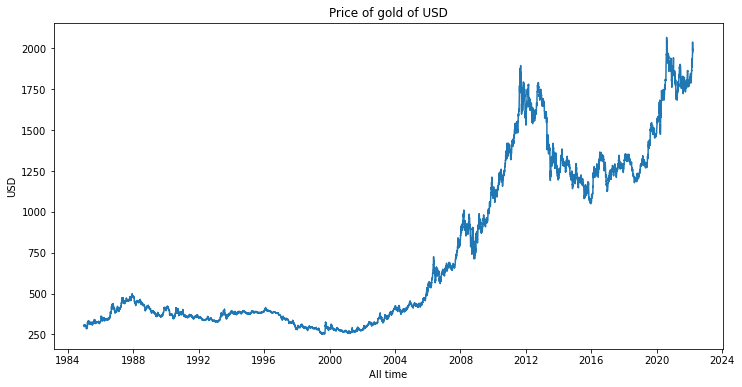

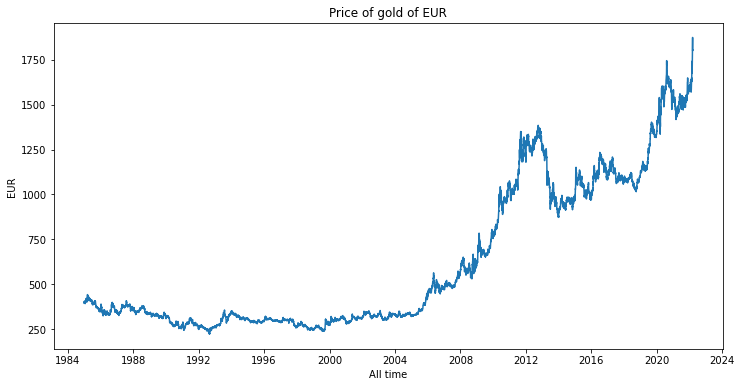

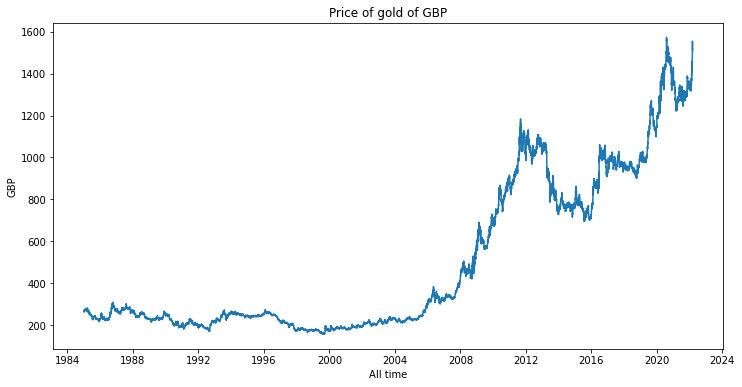

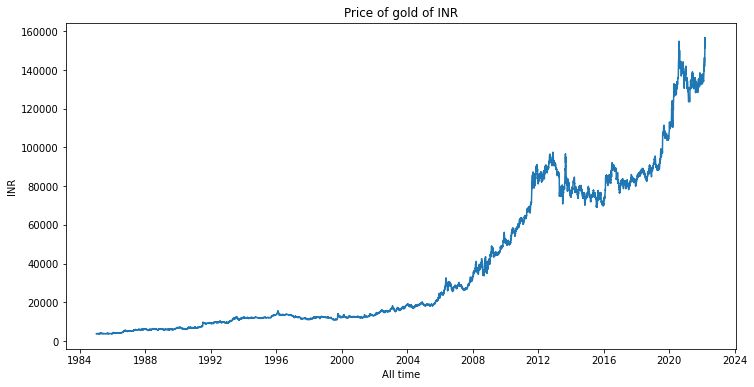

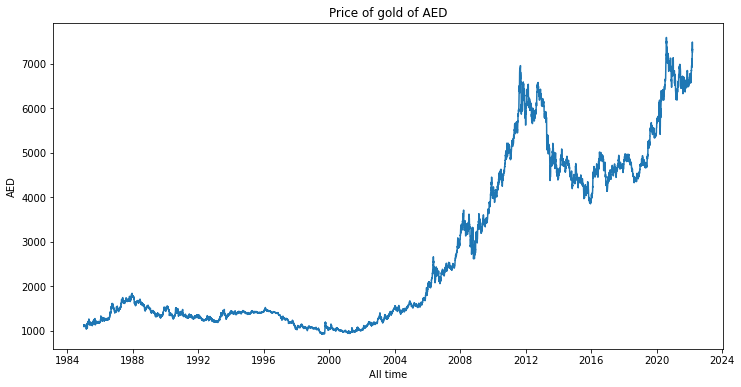

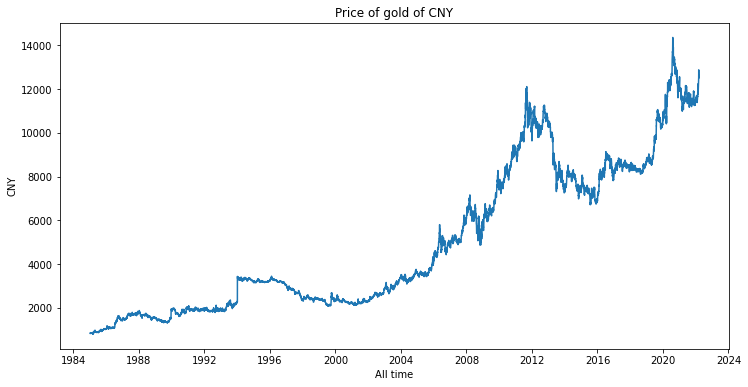

In [262]:
## Seaborn as Git don't show graph_objs
for i in currencies:
    plot_daily_sea_all(i)

### Asses Correlation

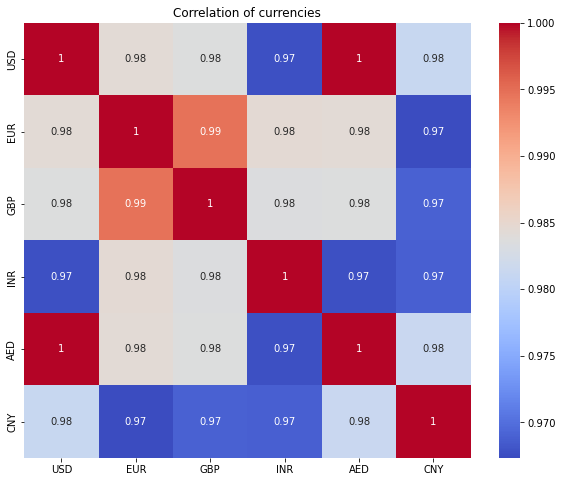

In [263]:
# Daily
correlation = daily.corr()
f, ax = plt.subplots(figsize=(10,8))
plt.title('Correlation of currencies')
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

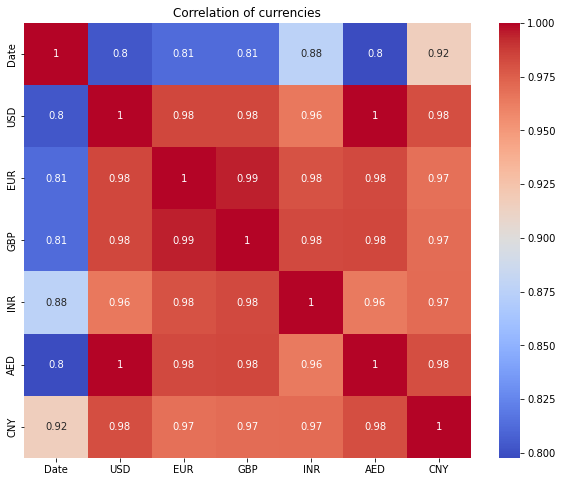

In [264]:
# Annual
correlation = annual.corr()
f, ax = plt.subplots(figsize=(10,8))
plt.title('Correlation of currencies')
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

There doesn't seem to be much different between daily ana annual data which make sense.
I will be mainly using daily dataset as it offer finer data and control.

---
## Modelling

In [265]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from joblib import dump, load
from xgboost import plot_importance, plot_tree

### Train/Val/Test Split

In [266]:
print("60%: ",daily['Date'].quantile(0.60))
print("80%: ",daily['Date'].quantile(0.80))

60%:  2007-04-25 19:12:00
80%:  2014-10-02 09:36:00


I will use `2007-04-25 19:12:00` and `2014-10-02 09:36:00` as cutoff date for 60/20/20 train/val/test.

In [267]:
daily1 = daily.set_index('Date')
daily1 = daily1.sort_index()

In [268]:
train_date = '2007-04-25 19:12:00'
val_date = '2014-10-02 09:36:00'
train = daily1.loc[: train_date].copy()
val = daily1.loc[train_date:val_date].copy()
test = daily1.loc[val_date :].copy()

In [269]:
print(f"Dates train      : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Dates validation      : {val.index.min()} --- {val.index.max()}  (n={len(val)})")
print(f"Dates test       : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dates train      : 1985-01-01 00:00:00 --- 2007-04-25 00:00:00  (n=5822)
Dates validation      : 2007-04-26 00:00:00 --- 2014-10-02 00:00:00  (n=1941)
Dates test       : 2014-10-03 00:00:00 --- 2022-03-11 00:00:00  (n=1941)


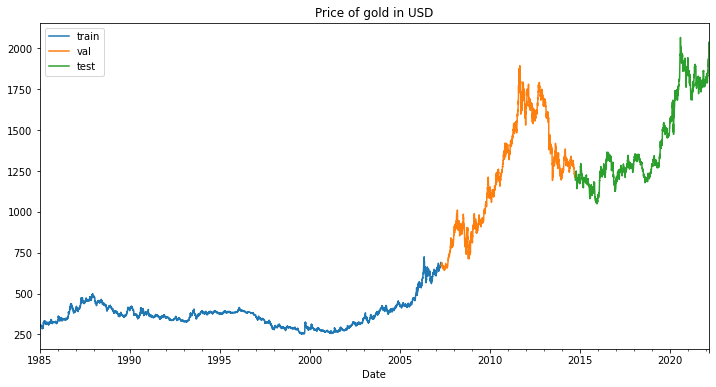

In [270]:
# Plot time series
fig, ax = plt.subplots(figsize=(12, 6))
train.plot(y='USD', ax=ax, label='train')
val.plot(y='USD', ax=ax, label='val')
test.plot(y='USD', ax=ax, label='test')
ax.set_title('Price of gold in USD')
ax.legend();

XGBoost is a very efficient stochastic gradient boosting which is very popular for used. With it's own API and XGBRegressor class that follow scikit learn API make it compatible with `skforecast`.

In [271]:
# Create forecaster
forecaster = ForecasterAutoreg(
                regressor = xgb.XGBRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters:

### Hyperparameter Tuning
Make sure that test data are not included as model can overfit. Things to note with each combination of hyperparameters and lags:
1. The model is trained with the training set.
2. The model is evaluated with the validation set using backtesting.
3. The combination of hyperparameters and lags with lowest error is selected.
4. The model is trained with the best combination found, this time using all the train and validation data.

In [319]:
#### Comment out as the best result can be found in below cell.
#--------------------------
# Grid search of hyperparameters and lags
# Regressor hyperparameters
# param_grid = {
#     'n_estimators': [100, 500],
#     'max_depth': [3, 5, 10],
#     'learning_rate': [0.01, 0.1]
#     }

# # Lags used as predictors
# lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

# results_grid = grid_search_forecaster(
#         forecaster         = forecaster,
#         y                  = daily1.loc[:val_date, 'USD'], # Train and validation data
#         param_grid         = param_grid,
#         lags_grid          = lags_grid,
#         steps              = 24,
#         refit              = False,
#         metric             = 'mean_squared_error',
#         initial_train_size = int(len(train)), # Model is trained with training data
#         fixed_train_size   = False,
#         return_best        = True,
#         verbose            = False
#         )

In [273]:
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",445624.805034,0.10,3.0,100.0
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",447857.404402,0.10,3.0,500.0
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",490080.838540,0.01,3.0,500.0
37,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",511544.814090,0.01,3.0,500.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",523168.398809,0.10,5.0,500.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",523798.011795,0.01,3.0,500.0
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",535145.043008,0.10,3.0,100.0
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",536231.461284,0.10,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",537882.042364,0.10,5.0,500.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",537907.754829,0.01,3.0,500.0


In [274]:
# `Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
#   Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
#  25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
#   Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
#   Backtesting metric: 445624.80503400863

### Backtesting test period

After we found the best combination using `validation data` we will applied into test set.

In [321]:
# Comment out
#==============
# Backtesting
# metric, predictions = backtesting_forecaster(
#     forecaster = forecaster,
#     y          = daily1['USD'],
#     initial_train_size = len(daily1.loc[:val_date]),
#     fixed_train_size   = False,
#     steps      = 24,
#     refit      = False,
#     metric     = 'mean_squared_error',
#     verbose    = False # Change to True to see detailed information
#     )

In [320]:
print(f"Backtest error: {metric}")

Backtest error: 6864.2382187111025


In [315]:
# Index is added to predictions
predictions.index = test.index

In [316]:
predictions

,pred
Date,
2014-10-03,1205.676025
2014-10-06,1205.676025
2014-10-07,1206.164795
2014-10-08,1205.676025
2014-10-09,1205.676025
...,...
2022-03-07,1731.320923
2022-03-08,1736.406738
2022-03-09,1742.924316


In [296]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 48 to 68
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pred    1941 non-null   float64
dtypes: float64(1)
memory usage: 30.3 KB


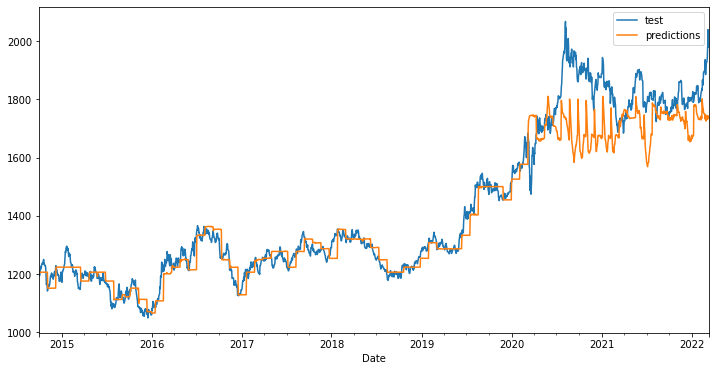

In [317]:
# Plot of predictions
fig, ax = plt.subplots(figsize=(12, 6))
test['USD'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

Now the result is improved form previous model. As you can see it's follow trend price quite well. There are some huge error during half of 2020 - 2022.
Still very promising overall. 
* I do believe that we can improve the model by adding Oil price and Bitcoin price as feature .
* Others interesting feature worth considering include moving average and others economic indicator for example

After improve the model we can try to use statmodel to see trend in the future.